Attempt to reproduce some VAE experiments using TensorFlow.  (MIT License)

https://arxiv.org/pdf/1312.6114.pdf  The paper

https://www.youtube.com/watch?v=rjZL7aguLAs  A presentation

http://github.com/dpkingma/nips14-ssl  The code for a different paper but which makes some things concrete

In [115]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [233]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [234]:
# model parameters
latent_dims = 10
hidden_units = 500
use_gaussian = False  # Bernoulli works WAY better (trains stabily in fewer epochs, does not overfit)

# training parameters
n_train = mnist.train.images.shape[0]
n_validation = mnist.validation.images.shape[0]
batch_size = 1000
learning_rate = 1e-5 if use_gaussian else 3e-4
max_train_secs = 3600
max_train_epochs_without_improvement = 10

In [235]:
# model inputs

# MNIST images
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')

# used to create z during training
epsilon = tf.placeholder(tf.float32, shape=[None, latent_dims], name='epsilon')

# used to specify z during generation
z = tf.placeholder(tf.float32, shape=[None, latent_dims], name='z')

In [236]:
# model setup helpers

# As in the paper, initialize by random sampling from N(0, 0.01)

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, dtype=tf.float32, name=name)

def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, dtype=tf.float32, name=name)

In [237]:
# model setup

# generative model (decoder) MLP parameters
theta_w3 = weight_variable([latent_dims, hidden_units], 'theta_w3')
theta_b3 = bias_variable([hidden_units], 'theta_b3')
theta_w4 = weight_variable([hidden_units, 784], 'theta_w4')
theta_b4 = bias_variable([784], 'theta_b4')
theta_w5 = weight_variable([hidden_units, 784], 'theta_w5')
theta_b5 = bias_variable([784], 'theta_b5')

# recognition model (encoder) MLP parameters
phi_w3 = weight_variable([784, hidden_units], 'phi_w3')
phi_b3 = bias_variable([hidden_units], 'phi_b3')
phi_w4 = weight_variable([hidden_units, latent_dims], 'phi_w4')
phi_b4 = bias_variable([latent_dims], 'phi_b4')
phi_w5 = weight_variable([hidden_units, latent_dims], 'phi_w5')
phi_b5 = bias_variable([latent_dims], 'phi_b5')

# p(z|x)
phi_h = tf.tanh(tf.matmul(x, phi_w3) + phi_b3)
phi_mu = tf.matmul(phi_h, phi_w4) + phi_b4
phi_logvar = tf.matmul(phi_h, phi_w5) + phi_b5

# p(x|z) using epsilon (used when learning)
z_est = phi_mu + (epsilon * tf.sqrt(tf.exp(phi_logvar)))
theta_h = tf.tanh(tf.matmul(z_est, theta_w3) + theta_b3)
# the sigmoid is not specified in appendix C, but is mentioned in section 5 (for Frey face data)
theta_mu = tf.sigmoid(tf.matmul(theta_h, theta_w4) + theta_b4)
theta_logvar = tf.matmul(theta_h, theta_w5) + theta_b5

# p(x|z) using z (used when generating)
gen_h = tf.tanh(tf.matmul(z, theta_w3) + theta_b3)
# the sigmoid is not specified in appendix C, but is mentioned in section 5 (for Frey face data)
gen_mu = tf.sigmoid(tf.matmul(gen_h, theta_w4) + theta_b4)
gen_logvar = tf.matmul(gen_h, theta_w5) + theta_b5

In [238]:
# training and evaluation helpers
import numpy as np

# negative log likelihood for a Gaussian
def normal_nll(X, mu, logvar):
    term1 = tf.reduce_sum(logvar)
    term2 = tf.reduce_sum(tf.ones_like(mu) * tf.log(tf.constant(2 * np.pi, dtype=tf.float32)))
    term3 = tf.reduce_sum(tf.pow(X - mu, tf.constant(2, dtype=tf.float32)) * tf.exp(tf.constant(-1.0, dtype=tf.float32) * logvar))
    nll = tf.constant(0.5, dtype=tf.float32) * (term1 + term2 + term3)
    return nll

def binary_crossentropy(output, target):
    return -((target * tf.log(output)) + \
             (((tf.constant(1, dtype=tf.float32)) - target) * tf.log(tf.constant(1, dtype=tf.float32)) - output))

def gaussian_next_batch():
    x_, y_ = mnist.train.next_batch(batch_size)
    return x_

def bernoulli_next_batch():
    x_, y_ = mnist.train.next_batch(batch_size)
    return np.random.binomial(n=1, p=x_).astype(np.float32)

In [239]:
# training and evaluation setup
gaussian_objective = normal_nll(x, theta_mu, theta_logvar) + \
                normal_nll(z_est, tf.zeros_like(z_est), tf.zeros_like(z_est)) - \
                normal_nll(z_est, phi_mu, phi_logvar)

# I think this should have different regularization terms
bernoulli_objective = tf.reduce_sum(binary_crossentropy(theta_mu, x)) + \
                normal_nll(z_est, tf.zeros_like(z_est), tf.zeros_like(z_est)) - \
                normal_nll(z_est, phi_mu, phi_logvar)

if use_gaussian:
    next_batch = gaussian_next_batch
    vae_objective = gaussian_objective
else:
    next_batch = bernoulli_next_batch
    vae_objective = bernoulli_objective

global_step = tf.Variable(0, name='global_step', trainable=False)

#
# The paper said Stepsizes were adapted with Adagrad [DHS10];
# the Adagrad global stepsize parameters were chosen from {0.01, 0.02, 0.1}
# based on performance on the training set in the first few iterations.
#

train_step = tf.train.AdamOptimizer(learning_rate).minimize(vae_objective, global_step=global_step)

In [240]:
# variable lifecycle setup: initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [241]:
# intialize variables
sess.run(init)

In [227]:
# train with manual oversight (skip if you want to train based on convergence)

for step in range(4000):
    x_ = next_batch()
    epsilon_ = np.random.randn(batch_size, latent_dims)
    print('step {} objective {}'.format(step,
                                        sess.run(vae_objective, feed_dict={x: x_, epsilon: epsilon_})))

    train_step.run(feed_dict={x: x_, epsilon: epsilon_})

step 0 objective 172460.0
step 1 objective 172041.03125
step 2 objective 173235.53125
step 3 objective 173253.140625
step 4 objective 172819.265625
step 5 objective 172966.265625
step 6 objective 171869.671875
step 7 objective 171870.75
step 8 objective 170857.15625
step 9 objective 170364.5625
step 10 objective 173625.453125
step 11 objective 174326.109375
step 12 objective 170550.875
step 13 objective 170731.5
step 14 objective 172117.71875
step 15 objective 171950.625
step 16 objective 174119.375
step 17 objective 171498.40625
step 18 objective 173056.84375
step 19 objective 171561.65625
step 20 objective 171774.796875
step 21 objective 171984.9375
step 22 objective 171428.109375
step 23 objective 175567.546875
step 24 objective 172263.078125
step 25 objective 170889.734375
step 26 objective 174061.96875
step 27 objective 171654.015625
step 28 objective 170428.25
step 29 objective 171233.359375
step 30 objective 173642.828125
step 31 objective 174425.171875
step 32 objective 173559.

In [249]:
# check the objective on the validation set (skip if you want to train based on convergence)
for vstep in range(n_validation // batch_size):
    x_ = mnist.validation.images[vstep * batch_size : (vstep + 1) * batch_size, ]
    epsilon_ = np.random.randn(batch_size, latent_dims)
    objective = sess.run(vae_objective, feed_dict={x: x_, epsilon: epsilon_})
    print('validation objective: {}'.format(objective))

validation objective: 160279.40625
validation objective: 163706.71875
validation objective: 164088.21875
validation objective: 158880.125
validation objective: 164924.96875


In [248]:
# check the objective on the training set (skip if you want to train based on convergence)
for tstep in range(n_train // batch_size):
    x_ = mnist.train.images[tstep * batch_size : (tstep + 1) * batch_size, ]
    epsilon_ = np.random.randn(batch_size, latent_dims)
    objective = sess.run(vae_objective, feed_dict={x: x_, epsilon: epsilon_})
    print('train objective: {}'.format(objective))

train objective: 162301.765625
train objective: 163526.671875
train objective: 161359.390625
train objective: 163270.5625
train objective: 163362.53125
train objective: 161010.15625
train objective: 163548.5
train objective: 162987.390625
train objective: 164131.453125
train objective: 161983.828125
train objective: 162186.875
train objective: 162486.453125
train objective: 163788.125
train objective: 161483.234375
train objective: 159589.640625
train objective: 162744.453125
train objective: 160247.109375
train objective: 160959.0
train objective: 162621.40625
train objective: 162013.765625
train objective: 162048.90625
train objective: 163050.421875
train objective: 159814.640625
train objective: 160824.6875
train objective: 160993.125
train objective: 161871.515625
train objective: 161986.21875
train objective: 162972.25
train objective: 161789.5
train objective: 160747.296875
train objective: 159766.53125
train objective: 162610.53125
train objective: 164058.421875
train objective:

In [229]:
# save the variables (skip if you want to train based on convergence)
save_path = saver.save(sess, './vae.save', global_step=global_step)
print('Model saved in file: {}'.format(save_path))

Model saved in file: ./vae.save-8000


In [242]:
# train based on convergence (this works poorly for Gaussian because of overfitting)
import time

best_objective = 1e99
epochs_since_best = 0

steps_per_epoch = (n_train // batch_size) * 2

start_time = time.time()
epoch = 0
while epochs_since_best < max_train_epochs_without_improvement:
    epoch += 1
    for step in range(steps_per_epoch):
        x_ = next_batch()
        epsilon_ = np.random.randn(batch_size, latent_dims)
        train_step.run(feed_dict={x: x_, epsilon: epsilon_})

    epsilon_ = np.random.randn(n_validation, latent_dims)
    objective = sess.run(vae_objective, feed_dict={x: mnist.validation.images, epsilon: epsilon_})
    print('epoch: {0} secs: {1:.3f} validation objective: {2}'.format(epoch, time.time() - start_time, objective))
    if objective < best_objective:
        # saving takes longer than optimization...why?
        save_path = saver.save(sess, './vae.save', global_step=global_step)
        print('Model saved in file: {}'.format(save_path))
        best_objective = objective
        epochs_since_best = 0
    else:
        epochs_since_best += 1

    if max_train_secs >= 0:
        if (time.time() - start_time) >= max_train_secs:
            print('Maximum training time reached')
            break

epoch: 1 validation objective: 1134906.0
Model saved in file: ./vae.save-110
epoch: 2 validation objective: 1028250.75
Model saved in file: ./vae.save-220
epoch: 3 validation objective: 984128.5625
Model saved in file: ./vae.save-330
epoch: 4 validation objective: 961545.125
Model saved in file: ./vae.save-440
epoch: 5 validation objective: 949386.0
Model saved in file: ./vae.save-550
epoch: 6 validation objective: 941622.125
Model saved in file: ./vae.save-660
epoch: 7 validation objective: 935753.0
Model saved in file: ./vae.save-770
epoch: 8 validation objective: 930949.875
Model saved in file: ./vae.save-880
epoch: 9 validation objective: 927192.125
Model saved in file: ./vae.save-990
epoch: 10 validation objective: 924107.25
Model saved in file: ./vae.save-1100
epoch: 11 validation objective: 920825.9375
Model saved in file: ./vae.save-1210
epoch: 12 validation objective: 917516.75
Model saved in file: ./vae.save-1320
epoch: 13 validation objective: 915116.1875
Model saved in file

In [243]:
# restore the last saved state, which is the lowest observed objective
saver.restore(sess, save_path)

INFO:tensorflow:Restoring parameters from ./vae.save-39600


In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

def img(floats):
    img = np.array(floats * 255, dtype='uint8')
    pixels = img.reshape((28, 28))
    return pixels

def disp(pixels):
    plt.imshow(pixels, cmap='gray')

def dispimg(floats):
    pixels = img(floats)
    disp(pixels)

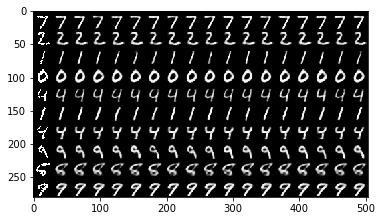

In [277]:
# for some test images, get associated latent variables (the posterior z distribution means),
# then use those to generate a new image (the posterior x distribution means), then sample
# from the posterior z and generate variation images.
n_images = 10
n_variations = 16
grid = np.zeros((n_images * 28, (2 + n_variations) * 28), dtype=np.float32)
row = 0
for i in range(n_images):
    if use_gaussian:
        x0 = np.array([mnist.test.images[i]])
    else:
        x0 = np.array([np.random.binomial(n=1, p=mnist.test.images[i]).astype(np.float32)])
    epsilon0 = np.zeros((1, latent_dims))
    z0_mu = sess.run(phi_mu, feed_dict={x:x0, epsilon:epsilon0})
    z0_logvar = sess.run(phi_logvar, feed_dict={x:x0, epsilon:epsilon0})
    xgen_mu = sess.run(gen_mu, feed_dict={z:z0_mu})
    #xgen_logvar = sess.run(gen_logvar, feed_dict={z:z0_mu})

    grid[row:row+28, 0:28] = img(x0[0])
    grid[row:row+28, 28:56] = img(xgen_mu[0])
    
    z_variations = np.sqrt(np.exp(z0_logvar)) * np.random.randn(n_variations, latent_dims) + z0_mu
    xgen_variations = sess.run(gen_mu, feed_dict={z:z_variations})

    column = 56
    for j in range(n_variations):
        grid[row:row+28, column:column+28] = img(xgen_variations[j])
        column += 28
    row += 28

disp(grid)

In [250]:
# for some test images, get associated latent variables (the posterior z distribution means),
# then use those to generate a new image (the posterior x distribution means)
for i in range(5):
    if use_gaussian:
        x0 = np.array([mnist.test.images[i]])
    else:
        x0 = np.array([np.random.binomial(n=1, p=mnist.test.images[i]).astype(np.float32)])
    epsilon0 = np.zeros((1, latent_dims))
    z0_mu = sess.run(phi_mu, feed_dict={x:x0, epsilon:epsilon0})
    z0_logvar = sess.run(phi_logvar, feed_dict={x:x0, epsilon:epsilon0})
    xgen_mu = sess.run(gen_mu, feed_dict={z:z0_mu})
    xgen_logvar = sess.run(gen_logvar, feed_dict={z:z0_mu})
    print('label: {} mu: {} logvar: {} xgen_mu: {} x0: {}'.format(mnist.test.labels[i], z0_mu, z0_logvar, xgen_mu, x0))

label: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.] mu: [[ 2.26664877  1.28151965  1.48287368  0.44001231  0.1437178  -1.14568126
   0.11526583 -0.07507212  0.26922679  0.18870598]] logvar: [[-3.2509737  -3.73936534 -2.35988235 -1.9846406  -2.32562804 -2.51645827
  -1.46959126 -4.20737743 -2.61085963 -1.36410594]] xgen_mu: [[  6.06485402e-13   6.12543382e-13   5.29491652e-13   2.92829427e-13
    5.09990542e-13   3.19531321e-13   3.42566524e-13   4.68537589e-13
    9.25637388e-13   1.59057460e-13   8.52828225e-13   5.49669197e-13
    9.35565722e-11   2.07189738e-10   1.90243155e-12   8.85727269e-10
    4.41469479e-13   3.64481476e-13   8.87982396e-13   9.16764386e-13
    1.47930184e-13   4.37024196e-13   3.83875928e-13   2.63531547e-13
    1.72223049e-13   1.99659571e-13   3.14022950e-13   3.10101120e-13
    1.95868780e-13   2.69442644e-13   1.12431494e-12   5.56593183e-13
    1.94665817e-09   1.13198606e-08   3.32127144e-08   2.18144418e-08
    5.68612677e-08   6.77222456e-09   3.80636038

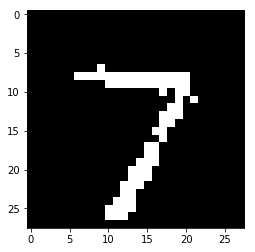

In [266]:
dispimg(x0[0])

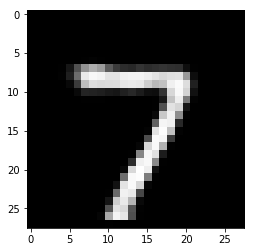

In [267]:
dispimg(xgen_mu[0])

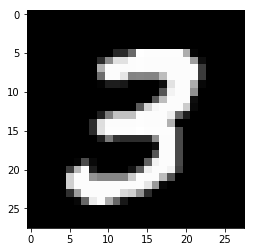

In [255]:
dispimg(mnist.validation.images[7])

In [256]:
print(sess.run(phi_w3, feed_dict={x:x0, epsilon:epsilon0}))
print(sess.run(phi_w4, feed_dict={x:x0, epsilon:epsilon0}))
print(sess.run(phi_w5, feed_dict={x:x0, epsilon:epsilon0}))

[[ 0.12398174  0.04684073  0.00688196 ...,  0.02471329  0.02035386
  -0.00606643]
 [ 0.0634625  -0.02160202  0.02770045 ...,  0.12522016  0.00533785
   0.18922278]
 [ 0.18416724 -0.02348058  0.01819656 ...,  0.05452962 -0.1651527
  -0.08097343]
 ..., 
 [ 0.01945168 -0.00200279 -0.02043207 ..., -0.01626358  0.12588604
  -0.15585421]
 [ 0.0570083  -0.10371917 -0.04785367 ...,  0.11677104 -0.04033309
  -0.00584292]
 [-0.00194027 -0.02112203 -0.0617192  ...,  0.01754938 -0.05803737
  -0.03875306]]
[[ 0.02320345 -0.04354816  0.03892699 ..., -0.00929469 -0.05619734
  -0.15172566]
 [ 0.02449472  0.0037682   0.01018346 ..., -0.04269406 -0.03323871
   0.03307535]
 [-0.05079528 -0.01018903  0.00134775 ...,  0.00544859  0.02465216
   0.03854276]
 ..., 
 [ 0.06698148  0.0175614  -0.00548067 ..., -0.02965525  0.07201327
  -0.13051225]
 [ 0.00089005  0.02326491 -0.01875521 ...,  0.01306994  0.01819899
  -0.0620028 ]
 [-0.12381075 -0.06103456  0.05381931 ...,  0.03386874 -0.08453359
   0.08556806]]
[

In [257]:
print(sess.run(phi_b3, feed_dict={x:x0, epsilon:epsilon0}))
print(sess.run(phi_b4, feed_dict={x:x0, epsilon:epsilon0}))
print(sess.run(phi_b5, feed_dict={x:x0, epsilon:epsilon0}))

[ -2.08990499e-01  -1.84304669e-01  -3.50220889e-01   3.14624190e-01
  -2.55711317e-01   1.84913009e-01  -1.35642797e-01  -6.15957640e-02
   9.95906163e-03  -4.90570590e-02   3.54925007e-01  -1.16024204e-01
  -1.91474054e-02  -1.64926827e-01   1.60176799e-01  -3.06715071e-01
  -2.10565835e-01   1.63289115e-01  -2.33738661e-01  -3.15197557e-01
  -1.99815765e-01   1.10882781e-01  -3.32439512e-01   6.66643530e-02
  -2.90788244e-02   1.64382383e-01   3.96290384e-02   6.17242083e-02
   2.76303440e-01  -4.43394333e-02  -5.42543568e-02  -3.37473899e-01
   1.29028171e-01  -1.55588165e-01   1.47735104e-01  -4.38619927e-02
   4.06086594e-01   8.77635553e-02  -1.31882146e-01  -2.02207148e-01
   1.36529222e-01  -1.90732732e-01   6.12502620e-02   2.15800196e-01
   3.44617516e-02   5.61172143e-03   1.10111013e-01  -3.11853766e-01
   1.13292448e-01  -1.73922013e-02   1.85016558e-01   1.45272747e-01
  -1.90481335e-01  -1.35040417e-01   8.91903117e-02   9.72712934e-02
   2.67034888e-01   2.65132964e-01

In [258]:
print(sess.run(phi_mu, feed_dict={x: x_}))

[[ 1.20040846  1.72904706  0.86771768 ..., -0.65155244  0.2652683
   0.36994779]
 [ 0.62637669 -0.90682602  0.311524   ...,  0.06442636 -0.99919748
   1.57039106]
 [ 0.07873899 -1.28703523  1.56312227 ..., -0.80067956  1.34558845
   0.5129196 ]
 ..., 
 [-0.26630789 -0.7052539   1.10126042 ..., -0.45225084 -1.36474454
  -0.06543119]
 [-1.27985156  1.47745442 -0.35791489 ...,  1.80546772  0.43675527
  -0.76031917]
 [-0.43803465 -0.47514307 -0.30784169 ...,  0.60014153 -2.13715863
   0.70989901]]
